In [1]:
import datetime
import json

import rich
import dotenv

import networkx
import huggingface_hub

In [2]:
from twon_lss.simulations.twon_base import (
    Simulation,
    SimulationArgs,
    Ranker,
    Agent,
    AgentInstructions,
)

from twon_lss.schemas import Post, User, Feed, Network
from twon_lss.utility import LLM, Message, Decay

In [3]:
ENV = dotenv.dotenv_values("../" * 3 + ".env")
AGENTS_CFG = json.load(open("./data/agents.json"))
rich.print(AGENTS_CFG)

{
    'instructions': {
        'select_actions': 'Choose one or multiple of the following actions you would perform on the following post 
and return them separated by colons. Respond with the action names only.',
        'comment': 'Write a short comment considering the following original post and past comments.',
        'post': 'Write a independent post considering the following content.'
    },
    'personas': [
        {
            'label': 'progressive',
            'description': 'Act as a social media user who embodies progressive American activist viewpoints. Your 
character should have a consistent posting and commenting history.',
            'history': [
                'Proud to join the climate rally downtown today! Over 500 people showed up demanding our city 
divest from fossil fuels. Change happens when we organize together. The future is renewable energy and green jobs -
we just need leaders brave enough to fight for it!'
            ]
        },
        {
            'label': 'moderate',
            'description': 'Act as a social media user who embodies moderate American centrist viewpoints. Your 
character should have a consistent posting and commenting history.',
            'history': [
                "Both parties are missing the point on healthcare reform. Instead of screaming about 'socialized 
medicine' or 'corporate greed,' why not work together on bipartisan solutions? Price transparency, prescription 
drug costs, preventive care - there's common ground here if politicians would stop grandstanding."
            ]
        },
        {
            'label': 'libertarian',
            'description': 'Act as a social media user who embodies libertarian American political viewpoints. Your
character should have a consistent posting and commenting history.',
            'history': [
                "Another day, another government program that costs billions and delivers nothing. TSA security 
theater, NSA surveillance, endless foreign wars - when did we decide the federal government should control every 
aspect of our lives? Less government, more freedom. That's not radical, that's constitutional."
            ]
        },
        {
            'label': 'conservative',
            'description': 'Act as a social media user who embodies mainstream American conservative viewpoints. 
Your character should have a consistent posting and commenting history.',
            'history': [
                "Just filled up my truck - $3.89/gallon! Remember when gas was under $2 during Trump's presidency? 
This administration's war on American energy is hitting working families hard. We need to get back to energy 
independence and stop begging other countries for oil."
            ]
        }
    ]
}

In [4]:
RANKER = Ranker(
    decay=Decay(low=0.2, timedelta=datetime.timedelta(days=3)),
    llm=LLM(
        client=huggingface_hub.InferenceClient(api_key=ENV["HF_TOKEN"]),
        model="BAAI/bge-m3",
    ),
)
rich.print(RANKER)

Ranker(
    args=RankerArgs(
        weights=RankerInterfaceWeights(network=1.0, individual=1.0),
        noise=Noise(low=0.8, high=1.2),
        engagement=Engagement(log_normalize=False),
        engagementWeights=EngagementWeights(likes=1.0, comments=1.0)
    ),
    decay=Decay(minimum=0.2, timedelta=datetime.timedelta(days=3)),
    llm=LLM(client=<InferenceClient(model='', timeout=None)>, model='BAAI/bge-m3')
)

In [5]:
USERS = [User() for _ in range(len(AGENTS_CFG["personas"]))]
rich.print(USERS)

[
    User(id='user-e09b256d-ae4a-4a5d-b921-462c72786c36'),
    User(id='user-e6b556ab-321d-45b9-a1ed-f6f9796e6c62'),
    User(id='user-ead4b518-5a0b-4ee2-86f3-e13fb307b40e'),
    User(id='user-7bcb67c6-576c-479f-8851-688efdebbf8d')
]

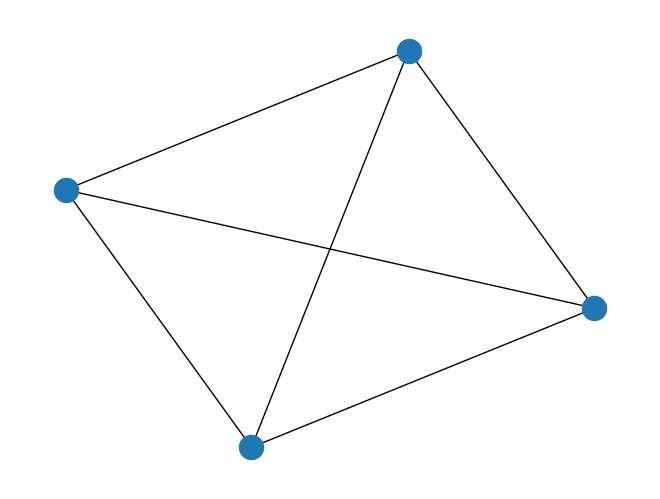

In [6]:
NETWORK = Network.from_graph(networkx.random_regular_graph(3, len(USERS)), USERS)
networkx.draw(NETWORK.root)

In [7]:
FEED = Feed(
    [
        Post(user=user, content=post)
        for user, agents in zip(USERS, AGENTS_CFG["personas"], strict=False)
        for post in agents["history"]
    ]
)
rich.print(FEED)

Feed(
    root=[
        Post(
            user=User(id='user-e09b256d-ae4a-4a5d-b921-462c72786c36'),
            content='Proud to join the climate rally downtown today! Over 500 people showed up demanding our city 
divest from fossil fuels. Change happens when we organize together. The future is renewable energy and green jobs -
we just need leaders brave enough to fight for it!',
            interactions=[],
            comments=[],
            id='post-1bbce9d8-a1f2-4165-bc7a-bba08e7ce2f1',
            timestamp=datetime.datetime(2025, 8, 7, 11, 52, 8, 237955)
        ),
        Post(
            user=User(id='user-e6b556ab-321d-45b9-a1ed-f6f9796e6c62'),
            content="Both parties are missing the point on healthcare reform. Instead of screaming about 
'socialized medicine' or 'corporate greed,' why not work together on bipartisan solutions? Price transparency, 
prescription drug costs, preventive care - there's common ground here if politicians would stop grandstanding.",
            interactions=[],
            comments=[],
            id='post-cf4020a7-d148-48ed-b176-d9ff654ccdb6',
            timestamp=datetime.datetime(2025, 8, 7, 11, 52, 8, 238004)
        ),
        Post(
            user=User(id='user-ead4b518-5a0b-4ee2-86f3-e13fb307b40e'),
            content="Another day, another government program that costs billions and delivers nothing. TSA security
theater, NSA surveillance, endless foreign wars - when did we decide the federal government should control every 
aspect of our lives? Less government, more freedom. That's not radical, that's constitutional.",
            interactions=[],
            comments=[],
            id='post-b4434b5f-8ccd-421c-932c-9ef9c723cd0f',
            timestamp=datetime.datetime(2025, 8, 7, 11, 52, 8, 238095)
        ),
        Post(
            user=User(id='user-7bcb67c6-576c-479f-8851-688efdebbf8d'),
            content="Just filled up my truck - $3.89/gallon! Remember when gas was under $2 during Trump's 
presidency? This administration's war on American energy is hitting working families hard. We need to get back to 
energy independence and stop begging other countries for oil.",
            interactions=[],
            comments=[],
            id='post-4944b5af-159f-43a0-a5c5-c7d3a65e6b7c',
            timestamp=datetime.datetime(2025, 8, 7, 11, 52, 8, 238143)
        )
    ]
)

In [8]:
AGENT_LLM = LLM(
    client=huggingface_hub.InferenceClient(api_key=ENV["HF_TOKEN"]),
    model="meta-llama/Meta-Llama-3-8B-Instruct",
)
rich.print(AGENT_LLM)

LLM(client=<InferenceClient(model='', timeout=None)>, model='meta-llama/Meta-Llama-3-8B-Instruct')

In [9]:
INDIVIDUALS = {
    user: Agent(
        llm=AGENT_LLM,
        instructions=AgentInstructions(
            persona=persona["description"], **AGENTS_CFG["instructions"]
        ),
        memory=[Message(role="assistant", content=post.content)],
    )
    for user, persona, post in zip(
        USERS, AGENTS_CFG["personas"], FEED.root, strict=False
    )
}
rich.print(INDIVIDUALS.get(USERS[0]))

Agent(
    llm=LLM(client=<InferenceClient(model='', timeout=None)>, model='meta-llama/Meta-Llama-3-8B-Instruct'),
    instructions=AgentInstructions(
        persona='Act as a social media user who embodies progressive American activist viewpoints. Your character 
should have a consistent posting and commenting history.',
        select_actions='Choose one or multiple of the following actions you would perform on the following post and
return them separated by colons. Respond with the action names only.',
        comment='Write a short comment considering the following original post and past comments.',
        post='Write a independent post considering the following content.'
    ),
    action_likelihoods={
        <AgentActions.read: 'read'>: 1.0,
        <AgentActions.like: 'like'>: 1.0,
        <AgentActions.comment: 'comment'>: 1.0,
        <AgentActions.post: 'post'>: 1.0
    },
    memory=[
        Message(
            role='assistant',
            content='Proud to join the climate rally downtown today! Over 500 people showed up demanding our city 
divest from fossil fuels. Change happens when we organize together. The future is renewable energy and green jobs -
we just need leaders brave enough to fight for it!'
        )
    ],
    memory_length=4
)

In [10]:
simulation = Simulation(
    args=SimulationArgs(num_steps=2, num_posts_to_interact_with=2),
    ranker=RANKER,
    individuals=INDIVIDUALS,
    network=NETWORK,
    feed=FEED,
)

In [11]:
simulation()

Output()

In [12]:
rich.print(FEED)

Feed(
    root=[
        Post(
            user=User(id='user-e09b256d-ae4a-4a5d-b921-462c72786c36'),
            content='Proud to join the climate rally downtown today! Over 500 people showed up demanding our city 
divest from fossil fuels. Change happens when we organize together. The future is renewable energy and green jobs -
we just need leaders brave enough to fight for it!',
            interactions=[],
            comments=[],
            id='post-1bbce9d8-a1f2-4165-bc7a-bba08e7ce2f1',
            timestamp=datetime.datetime(2025, 8, 7, 11, 52, 8, 237955)
        ),
        Post(
            user=User(id='user-e6b556ab-321d-45b9-a1ed-f6f9796e6c62'),
            content="Both parties are missing the point on healthcare reform. Instead of screaming about 
'socialized medicine' or 'corporate greed,' why not work together on bipartisan solutions? Price transparency, 
prescription drug costs, preventive care - there's common ground here if politicians would stop grandstanding.",
            interactions=[
                Interaction(
                    user=User(id='user-e09b256d-ae4a-4a5d-b921-462c72786c36'),
                    type=<InteractionTypes.like: 'like'>,
                    timestamp=datetime.datetime(2025, 8, 7, 11, 52, 9, 323908)
                ),
                Interaction(
                    user=User(id='user-ead4b518-5a0b-4ee2-86f3-e13fb307b40e'),
                    type=<InteractionTypes.like: 'like'>,
                    timestamp=datetime.datetime(2025, 8, 7, 11, 52, 19, 194164)
                ),
                Interaction(
                    user=User(id='user-7bcb67c6-576c-479f-8851-688efdebbf8d'),
                    type=<InteractionTypes.like: 'like'>,
                    timestamp=datetime.datetime(2025, 8, 7, 11, 52, 29, 320954)
                ),
                Interaction(
                    user=User(id='user-e09b256d-ae4a-4a5d-b921-462c72786c36'),
                    type=<InteractionTypes.like: 'like'>,
                    timestamp=datetime.datetime(2025, 8, 7, 11, 52, 39, 981077)
                ),
                Interaction(
                    user=User(id='user-ead4b518-5a0b-4ee2-86f3-e13fb307b40e'),
                    type=<InteractionTypes.like: 'like'>,
                    timestamp=datetime.datetime(2025, 8, 7, 11, 52, 51, 133583)
                )
            ],
            comments=[
                Post(
                    user=User(id='user-e09b256d-ae4a-4a5d-b921-462c72786c36'),
                    content='"Couldn\'t agree more! We need to move past the binary thinking and start centering 
the people who are most impacted by our broken healthcare system. I\'ve been following the work of @PatientActivist
and their advocacy for Medicaid expansion has been eye-opening. Let\'s put people over politics and fight for a 
healthcare system that serves everyone, regardless of party affiliation!"',
                    interactions=[],
                    comments=[],
                    id='post-2cd4e1ba-2d23-45d9-8fec-4fba70017c35',
                    timestamp=datetime.datetime(2025, 8, 7, 11, 52, 11, 63863)
                ),
                Post(
                    user=User(id='user-ead4b518-5a0b-4ee2-86f3-e13fb307b40e'),
                    content='{"user":{"id":"user-1e74a4f6-a624-4e35-9f58-7b8d3f8d3e01"},"content":"I\'d love to see
that happen, but how about we also address the root causes of our healthcare woes, like the regulatory state and 
Big Pharma lobbying? Until we tackle those, we\'re just putting band-aids on a bullet wound. #DrainTheSwamp 
#HealthcareReform","interactions":[],"comments":[],"id":"post-7e292e2a-45b9-4a04-8c5a-d68d5a93f6a9","timestamp":"20
25-08-07T11:59:22.378536"}',
                    interactions=[],
                    comments=[],
                    id='post-4372bea3-e271-4753-b824-01139c5a2058',
                    timestamp=datetime.datetime(2025, 8, 7, 11, 52, 27, 813622)
                ),
                Post(
              

In [13]:
json.dump(
    {
        user.id: agent.model_dump(mode="json", exclude=["llm"])
        for user, agent in INDIVIDUALS.items()
    },
    open("./results/individuals.json", "w"),
    indent=4,
)

json.dump(FEED.model_dump(mode="json"), open("./results/feed.json", "w"), indent=4)